In [1]:
from itertools import chain
from collections import defaultdict, Counter
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from utils import split_data_regression, add_coordinates

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = "all"

from utils import draw_regression_accuracy

draw_accuracy = lambda model, params: draw_regression_accuracy(df, 40, 300, 400, 8, model, params)

In [2]:
np.random.seed(42)

# Regression

## Data processing

During classification we have encountered with problem, that information about correct/uncorrect squares are not enough for understanding. More naturaly for localization to see error, as difference between true point and predicted in 2D plain. To do so, we wanted to try Regression based approach, where we will be predicting **x** and **y** coordinates.

To do so we will use the fact, that while collecting data for fingerprinting 10 points where chosen not randomly but with next scheme:

![Subsquare division](./photos/fingerprinting_2/sub_square_division.png)

as square naturally divides into 9 points, we have done so, and tenth point was just measured a little bit lefter.

In [3]:
df = pd.read_csv('../data/fingerprinting_2.csv', index_col='Unnamed: 0')
df = df.reset_index(drop=True)

During the data gathering for 2 and 3 squares (s1 and s2) we have lost 1 orientation measurement (100 samples). As each subsequnt measurement is very similar to previous one and we don't use **Orientation** for predicting, then we can just duplicate the last 100 samples to have our data equable.

In [4]:
grouped = df.groupby("Square")

point1 = grouped.get_group("s1").iloc[-100:]
point1["Point"] = 39
point1["Orientation"] = 3.0

point2 = grouped.get_group("s2").iloc[-100:]
point2["Point"] = 39
point2["Orientation"] = 3.0

df = df.append([point1, point2]).reset_index(drop=True)

So, to get specific coordinates for each of 10 points in plain (for each we have measured 100 samples in 4 orientations) we will use next info:

- size of stool, on which was microcontroller was 40x40 cm
- stool was aligned to side of square or placed in center between two sides
- the order of points in square:
<pre>
  1    2    3
  8    9 10 4
  7    6    5
</pre>

In [5]:
df = add_coordinates(df)
df

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5,Square,Point,Orientation,x,y
0,-55,-71,-69,-57,-58,s0,0,0.0,20,380
1,-57,-64,-58,-48,-58,s0,0,0.0,20,380
2,-57,-64,-58,-48,-58,s0,0,0.0,20,380
3,-57,-64,-57,-48,-58,s0,0,0.0,20,380
4,-57,-65,-57,-48,-58,s0,0,0.0,20,380
...,...,...,...,...,...,...,...,...,...,...
47995,-64,-64,-74,-53,-35,s2,39,3.0,254,350
47996,-63,-65,-72,-53,-35,s2,39,3.0,254,350
47997,-63,-65,-72,-54,-35,s2,39,3.0,254,350
47998,-63,-65,-72,-53,-35,s2,39,3.0,254,350


In [6]:
grouped = df.groupby(["Point"])
data = grouped.get_group(0).groupby(["Square"]).get_group("s4")
model_rf.predict(data[["Server-RSSI-" + str(i) for i in range(1, 6)]]) - data[["x", "y"]]

NameError: name 'model_rf' is not defined

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data_regression(
    df, points_num=40, train_part=0.7, validation_part=0.15, test_part=0.15)

To handle, that we need to find **x** and **y** coordinates, we will use MultiOuputRegressor, which will just make one regressor for each target column

## Model

First, we wanted to use Decision based regression, as it is very similar to classification (it is actually classifacation), but model will divide continious space on bins by itself, so we don't need to think is it better to have square with 1 m side length or 10 cm.

In [7]:
# minimizing distance
def model_accuracy(params,model,train_data,train_labels,cv_data,cv_labels):
    model = MultiOutputRegressor(model(**params))
    model.fit(train_data, train_labels)
    preds = model.predict(cv_data)
    return {'loss': np.mean(np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(preds - cv_labels))), 'status': STATUS_OK}

In [ ]:
# setting the space
max_depth = np.arange(3, 20, dtype=int)
sampling_method = ['gradient_based', 'uniform']
xgb_fspace = {
    'eta':hp.uniform('eta', 0.01, 1),
    'gamma':hp.uniform('gamma', 0.01, 1),
    'max_depth':hp.choice('max_depth', max_depth),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'subsample': hp.uniform('subsample', 0, 1), 
    'sampling_method': hp.choice('sampling_method',sampling_method)
}

xgb_accuracy = lambda x:model_accuracy(x,model=XGBRegressor,train_data=X_train,train_labels=y_train,cv_data=X_val,cv_labels=y_val)
trials = Trials()
best_xgb = fmin(
    fn=xgb_accuracy,
    space=xgb_fspace,
    algo=tpe.suggest,
    max_evals=50, trials=trials, rstate=np.random.RandomState(0))
best_xgb['sampling_method']=sampling_method[best_xgb['sampling_method']]
best_xgb['max_depth']=max_depth[best_xgb['max_depth']]
print('Best parameters: ')
for param in best_xgb:
    print(param, best_xgb[param])

In [8]:
best_xgb = {
    "eta": 0.031067719583302122,
    "gamma": 0.6239296575409805,
    "max_depth": 13,
    "min_child_weight": 0.360699687865366,
    "sampling_method": "gradient_based",
    "subsample": 0.0038370187252436128
}

In [ ]:
model_xgb = MultiOutputRegressor(XGBRegressor(**best_xgb,random_state=42))

model_xgb.fit(X_train, y_train)
predicted_xgb = model_xgb.predict(X_val)

In [ ]:
np.mean(np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(predicted_xgb - y_val)))

In [ ]:
draw_accuracy(XGBRegressor, best_xgb)

In [ ]:
max_features=np.arange(1,5,dtype=int)
n_estimators=np.arange(100,201,50)
rf_fspace = {
    'max_depth':hp.choice('max_depth', max_depth),
    'max_features': hp.choice('max_features', max_features),
    'n_estimators': hp.choice('n_estimators',n_estimators )
}

rf_accuracy = lambda x:model_accuracy(x,model=RandomForestRegressor,train_data=X_train,train_labels=y_train,cv_data=X_val,cv_labels=y_val)
trials = Trials()
best_rf = fmin(
    fn=rf_accuracy,
    space=rf_fspace,
    algo=tpe.suggest,
    max_evals=50, trials=trials, rstate=np.random.RandomState(0))
best_rf['max_features']=max_features[best_rf['max_features']]
best_rf['n_estimators']=n_estimators[best_rf['n_estimators']]
best_rf['max_depth']=max_depth[best_rf['max_depth']]
print('Best parameters: ')
for param in best_rf:
    print(param, best_rf[param])

In [8]:
best_rf = {
    "max_depth": 4,
    "max_features": 4,
    "n_estimators": 200
}

In [9]:
model_rf = MultiOutputRegressor(RandomForestRegressor(**best_rf,random_state=42))

model_rf.fit(X_train, y_train)
predicted_rf = model_rf.predict(X_val)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

In [10]:
X_train

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5
1900,-66,-65,-66,-61,-54
1901,-71,-57,-61,-51,-53
1902,-71,-57,-61,-52,-51
1903,-79,-57,-63,-53,-51
1904,-71,-59,-62,-53,-52
...,...,...,...,...,...
47495,-73,-47,-62,-56,-57
47496,-73,-47,-62,-57,-57
47497,-73,-47,-62,-56,-57
47498,-73,-47,-62,-56,-57


In [11]:
np.mean(np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(predicted_rf - y_val)))

103.4035601555301

In [ ]:
draw_accuracy()

In [13]:
from utils import get_samples_by_points_num
import itertools

def split_data_regression_cv(df, points_num, n_splits):
    division = np.split(np.random.permutation(np.arange(points_num)), n_splits)

    for i in range(len(division)):
        train = np.hstack(division[:i] + division[i+1:])
        test = division[i]
        yield itertools.chain.from_iterable(
            map(lambda data: (data.drop(columns=["Point", "Square", "Orientation", "x", "y"]), data[["x", "y"]]),
                map(lambda points: get_samples_by_points_num(df, points), [train, test])))

res = pd.DataFrame(columns=["x", "y", "accuracy"])
for X_train, y_train, X_test, y_test in split_data_regression_cv(df, 40, 8):
    model = MultiOutputRegressor(RandomForestRegressor(**best_rf))
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    res = pd.concat([res, pd.DataFrame({"x": y_test["x"].values, "y": y_test["y"].values, "accuracy": np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(predicted - y_test))})])

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=4,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n

In [ ]:
# X = df[["Server-RSSI-" + str(i) for i in range(1, 6)]].values
# predicted = model_rf.predict(X)

# coords = df[["x", "y"]].values

# res = pd.DataFrame({"x": df["x"].values, "y": df["y"].values, "accuracy": np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(predicted - coords))})

In [14]:
mean_res = res.groupby(["x", "y"]).mean().reset_index()
coords = mean_res[["x", "y"]].values

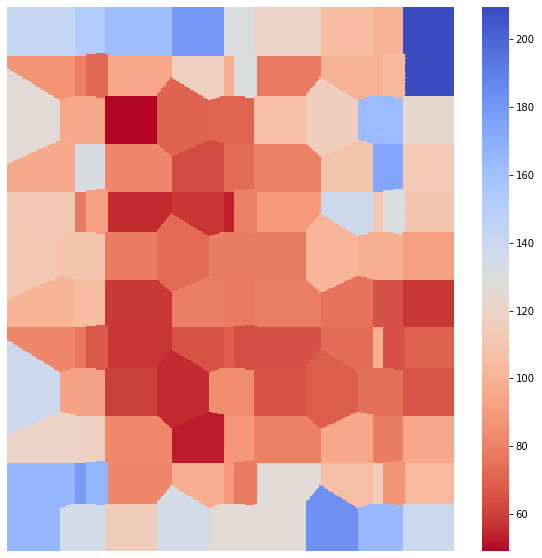

In [16]:
from utils import cartesian_cross_product

field = np.zeros((400,300))
for p in cartesian_cross_product(np.arange(field.shape[1]), np.arange(field.shape[0])):
    field[p[1], p[0]] = mean_res.iloc[np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(coords - p)).argmin(), 2]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(field, ax=ax, xticklabels=False,yticklabels=False,cmap="coolwarm_r")

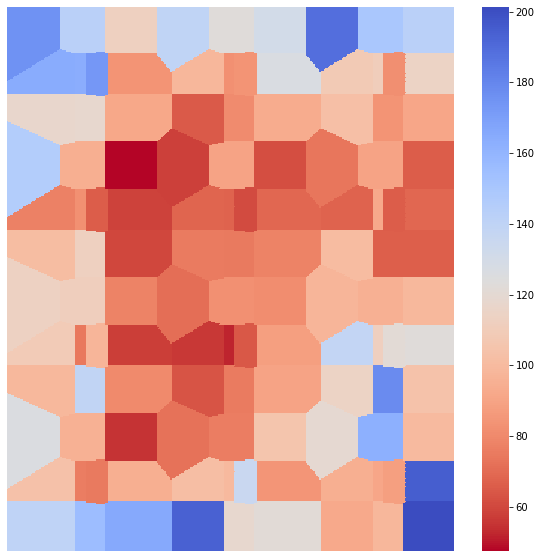

In [12]:
draw_accuracy(RandomForestRegressor, best_rf)

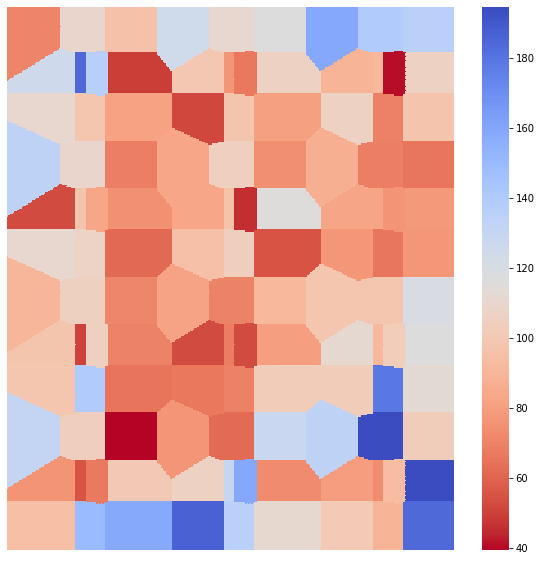

In [13]:
draw_accuracy(SVR, {})

In [13]:
scaler = MinMaxScaler()
numeric = ['Server-RSSI-1', 'Server-RSSI-2', 'Server-RSSI-3', 'Server-RSSI-4','Server-RSSI-5']
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)

In [14]:
model_linear = MultiOutputRegressor(LinearRegression(normalize=True))

model_linear.fit(X_train, y_train)
predicted_linear = model_linear.predict(X_val)

MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=True),
                     n_jobs=None)

In [15]:
np.mean(np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(y_scaler.inverse_transform(predicted_linear)-y_scaler.inverse_transform(y_val))))

110.42504151642284

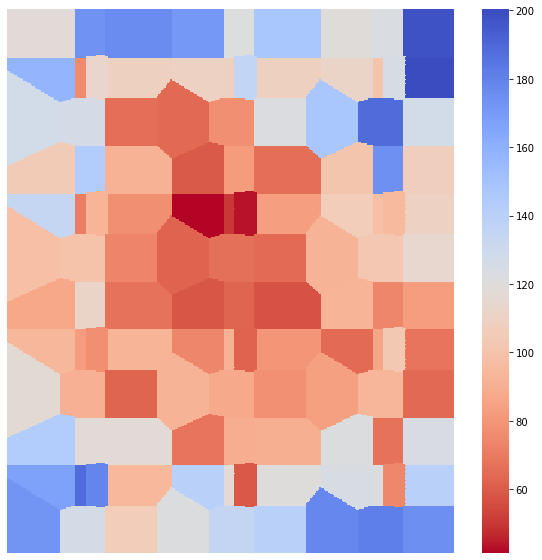

In [17]:
draw_accuracy(LinearRegression, {})

In [16]:
kernel=["poly", "rbf"]
gamma=['scale', 'auto']
svm_fspace = {
    'kernel': hp.choice('kernel',kernel),
    'gamma': hp.choice('gamma',gamma),
    'C':hp.uniform('C', 1, 10),
    
}

svm_accuracy = lambda x:model_accuracy(x,model=SVR,train_data=X_train,train_labels=y_train,cv_data=X_val,cv_labels=y_val)
trials = Trials()
best_svm = fmin(
    fn=svm_accuracy,
    space=svm_fspace,
    algo=tpe.suggest,
    max_evals=10, trials=trials, rstate=np.random.RandomState(0))
best_svm['kernel']=kernel[best_svm['kernel']]
best_svm['gamma']=gamma[best_svm['gamma']]
print('Best parameters: ')
for param in best_svm:
    print(param, best_rf[param])

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: name 'model_accuracy' is not defined



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]


NameError: name 'model_accuracy' is not defined

In [ ]:
model_svm = MultiOutputRegressor(SVR(**best_svm))

model_svm.fit(X_train, y_train)
predicted_svm = model_svm.predict(X_val)

In [ ]:
np.mean(np.apply_along_axis(lambda x: (x[0]**2 + x[1]**2)**0.5, 1, np.abs(predicted_svm - y_val)))

//TODO: Add visualizations

In [ ]:
pd.DataFrame({"x": y_val["x"].values, 
              "y": y_val["y"].values,
              'predicted_x': predicted[:, 0], 
              'predicted_y': predicted[:, 1]}).iloc[:100]

## Results